In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import os
from scipy import misc
import json
import pprint
import time

%matplotlib inline

In [2]:
OPENPOSE_ROOT = '/home/albert/openpose/'
POSE_ID_ROOT = '/home/albert/openpose/albert/pose_id/'

# POSE_ID_ROOT = '/Users/tradergllc/openpose/pose_id/'

In [3]:
def run_openpose(img, delete=True):
    OPENPOSE_ROOT = '/home/albert/openpose/'
    TMP_ROOT = "/home/albert/openpose/tmp/"
    file_root = str(int(time.time()))
    misc.imsave(TMP_ROOT + file_root + '.png', img)
    
    openpose_command = "./build/examples/openpose/openpose.bin \
            --image_dir tmp \
            --write_images tmp/render \
            --write_keypoint_json tmp/pose \
            --heatmaps_add_parts --heatmaps_add_bkg \
            --heatmaps_add_PAFs \
            --write_heatmaps tmp/htmps"
    %cd $OPENPOSE_ROOT
    os.system(openpose_command)
    
    img_file = TMP_ROOT + file_root + '.png'
    key_file = TMP_ROOT + 'pose/' + file_root + '_keypoints.json'
    render_file = TMP_ROOT + 'render/' + file_root + '_rendered.png'
    htmp_file = TMP_ROOT + 'htmps/' + file_root + '_heatmaps.png'
    
    with open(key_file) as data_file:    
        data = json.load(data_file)
        
    render = misc.imread(render_file)
    htmp = misc.imread(htmp_file)
    
    if delete:
        os.system('rm ' + img_file + ' ' + key_file + ' ' + render_file + ' ' + htmp_file)

    return data, render, htmp

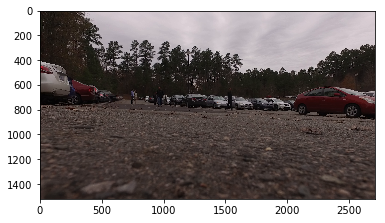

In [4]:
img = misc.imread(POSE_ID_ROOT + 'DJI_seq/DJI_0005_0.png')
plt.imshow(img)

In [5]:
!pwd

/home/albert/openpose/albert/pose_id


In [6]:
def run_scale(img, iterations=1, delete=True):
    pose = []
    
    for r in range(2**iterations):
        for c in range(2**iterations):
            frame = img[int(r * img.shape[0] / 2.0):int((r + 1) * img.shape[0] / 2.0),
                        int(c * img.shape[1] / 2.0):int((c + 1) * img.shape[1] / 2.0)]
            
            data, render, htmp = run_openpose(frame, delete=delete)
            
            if len(data['people']) > 0:
                for p in data['people']:
                    pose.append((np.array(p['pose_keypoints']).reshape((len(p['pose_keypoints'])/3, 3)) + 
                                     np.array([int(c * img.shape[1] / 2.0), int(r * img.shape[0] / 2.0), 0])).tolist())
            
            plt.figure(figsize=(8,3))
            plt.subplot(121)
            plt.imshow(frame)
            plt.title("Row: %d, Column: %d" % (r, c))
            plt.subplot(122)
            plt.imshow(render)
            plt.title("Render, Row: %d, Column: %d" % (r, c))
            plt.show()
    
    return pose

/home/albert/openpose


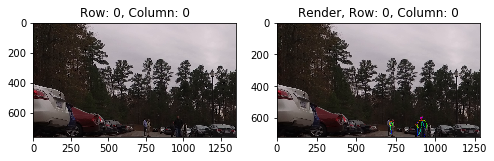

/home/albert/openpose


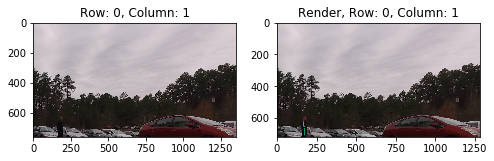

/home/albert/openpose


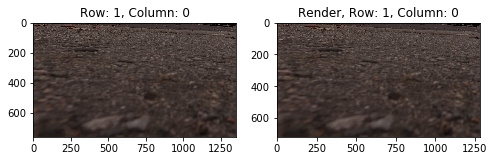

/home/albert/openpose


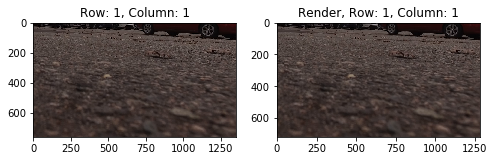

In [7]:
pose_data = run_scale(img)

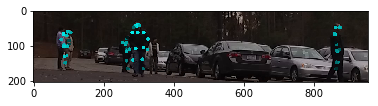

In [8]:
render_pre = misc.imread(POSE_ID_ROOT + 'DJI_seq/DJI_0005_0.png')

for person in pose_data:
    for k in person:
        render_pre = cv2.circle(render_pre,(int(k[0]),int(k[1])), 5, (0,int(255 * k[2]),int(255 * k[2])), -1)


x_max_z, x_min_z = 0, img.shape[1]
y_max_z, y_min_z = 0, img.shape[0]

for person in pose_data:
    for k in person:
        x, y = k[0], k[1]
        
        if x < x_min_z and x > 0:
            x_min_z = x
        if x > x_max_z:
            x_max_z = x
        if y < y_min_z and y > 0:
            y_min_z = y
        if y > y_max_z:
            y_max_z = y

diff_x_z = x_max_z - x_min_z
diff_y_z = y_max_z - y_min_z
r_x_z = 0.1
r_y_z = 0.3

plt.imshow(render_pre[int(y_min_z-r_y_z*diff_y_z):int(y_max_z+r_y_z*diff_y_z),
                      int(x_min_z-r_x_z*diff_x_z):int(x_max_z+r_x_z*diff_x_z)])

In [9]:
pose_zoom, render_zoom, _ = run_openpose(img[int(y_min_z-r_y_z*diff_y_z):int(y_max_z+r_y_z*diff_y_z),
                                             int(x_min_z-r_x_z*diff_x_z):int(x_max_z+r_x_z*diff_x_z)])

/home/albert/openpose


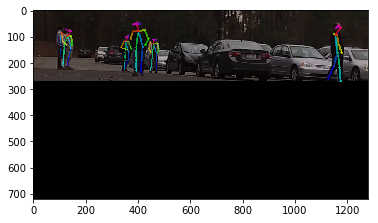

In [10]:
plt.imshow(render_zoom)

In [11]:
pose = []
for p in range(len(pose_zoom['people'])):
    pose.append([])
    for k in np.array(pose_zoom['people'][p]['pose_keypoints']).reshape((len(pose_zoom['people'][p]['pose_keypoints'])/3, 3)):
        if k[2] > 0:
            pose[p].append((np.array(k).astype(np.float64) + 
                           np.array([x_min_z-r_x_z*diff_x_z, y_min_z-r_y_z*diff_y_z, 0])).tolist())
        else:
            pose[p].append([0,0,0])

In [12]:
render = misc.imread(POSE_ID_ROOT + 'DJI_seq/DJI_0005_0.png')

people = []

for person in pose:
    for k in person:
        render = cv2.circle(render,(int(k[0]),int(k[1])), 5, (0,int(255 * k[2]),int(255 * k[2])), -1)

    x_max, x_min = 0, img.shape[1]
    y_max, y_min = 0, img.shape[0]

    for k in person:
        x, y = k[0], k[1]

        if x < x_min and x > 0:
            x_min = x
        if x > x_max:
            x_max = x
        if y < y_min and y > 0:
            y_min = y
        if y > y_max:
            y_max = y
    
    diff_x = x_max - x_min
    diff_y = y_max - y_min
    r_x = 0.5
    r_y = 0.2
    render = cv2.rectangle(render, (int(x_min-r_x*diff_x),int(y_min-r_y*diff_y)), 
                                 (int(x_max+r_x*diff_x),int(y_max+r_y*diff_y)), 
                                 (0,255,0), 3)
    
    people.append(img[int(y_min-r_y*diff_y):int(y_max+r_y*diff_y), 
                      int(x_min-r_x*diff_x):int(x_max+r_x*diff_x)])

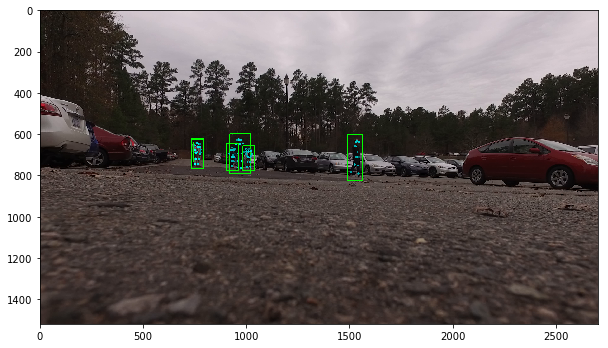

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(render)

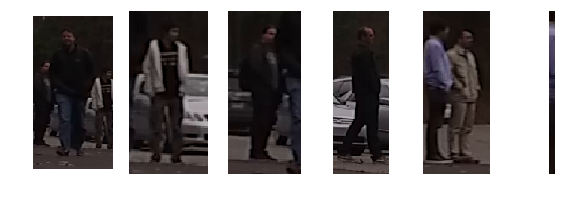

In [14]:
plt.figure(figsize=(10,3))
for i in range(len(people)):
    plt.subplot(1, len(people), i + 1)
    plt.imshow(people[i])
    plt.axis('off')
plt.show()